# Phase 3 — VQE for the Heisenberg Spin Chain

Our goal is to use the Variational Quantum Eigensolver (VQE) to estimate
the **ground-state energy** of a small Heisenberg spin chain.

Instead of simulating how the state changes in time, we will:

- Choose a **parameterized circuit** (ansatz) for a trial state $|\psi(\theta)\rangle$,
- Compute its **energy** with respect to the Heisenberg Hamiltonian,
- Use a **classical optimizer** to adjust $\theta$ until the energy is (hopefully) as low as possible.

For a small chain we can still diagonalize the Hamiltonian exactly, so we will compare
our VQE estimate to the exact ground-state energy and then see how things change once
we add noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_aer import AerSimulator

np.random.seed(16)

# Basic model settings
NUM_QUBITS = 4
J_COUPLING = 1.0

def num_params_for_depth(depth, num_qubits=NUM_QUBITS):
    return num_qubits * depth

print(f"Using {NUM_QUBITS}-qubit Heisenberg chain with J = {J_COUPLING}")


Using 4-qubit Heisenberg chain with J = 1.0


## Background

In Phase 3 we use the Variational Quantum Eigensolver (VQE) to estimate the **ground-state
energy** of a Heisenberg spin chain. Instead of simulating time evolution, we prepare a
parameterized trial state $\ket{\psi(\theta)}$ and minimize its energy.

### Heisenberg Hamiltonian

For a 1D chain with nearest-neighbor interactions, the Hamiltonian is

$$
H = J \sum_{\langle i,j \rangle}
\left(
\sigma_i^x \sigma_j^x
+ \sigma_i^y \sigma_j^y
+ \sigma_i^z \sigma_j^z
\right),
$$

where $\sigma_i^\alpha$ is the Pauli matrix $\sigma^\alpha$ acting on qubit (site) $i$.

Each product such as $\sigma_i^x \sigma_j^x$ is a **Pauli string**, and the full Hamiltonian is a sum of these strings.

### Variational principle

Given an ansatz state $\ket{\psi(\theta)}$, its energy is

$$
E(\theta) =
\bra{\psi(\theta)} H \ket{\psi(\theta)}.
$$

Because we can write the Hamiltonian as

$$
H = \sum_k h_k P_k,
$$

the energy becomes

$$
E(\theta) = \sum_k h_k \langle P_k \rangle,
$$

where each expectation value corresponds to a measurable Pauli string.

The variational principle guarantees

$$
E(\theta) \ge E_0,
$$

so minimizing $E(\theta)$ gives an estimate of the ground-state energy.

This notebook will:

- encode the Heisenberg Hamiltonian as Pauli strings,
- build a parameterized ansatz circuit,
- perform VQE optimization,
- compare with exact diagonalization,
- and explore the effect of noise.


## Constructing the Heisenberg Hamiltonian in Qiskit

We now translate the Heisenberg Hamiltonian into a form that Qiskit can work with.

For a 1D chain with nearest-neighbor interactions, the Hamiltonian is

$$
H = J \sum_{\langle i,j \rangle}
\left(
X_i X_j + Y_i Y_j + Z_i Z_j
\right).
$$

To implement this, we loop over all neighboring qubit pairs and add the
corresponding Pauli strings. Qiskit represents these terms using the
`SparsePauliOp` class, which stores each Pauli string and its coefficient.

We start by building a list of `(Pauli string, coefficient)` pairs and then
combine them into a single operator.


In [2]:
from qiskit.quantum_info import SparsePauliOp

def heisenberg_hamiltonian(num_qubits, J=1.0):

    paulis = []
    coeffs = []

    for i in range(num_qubits - 1):
        
        # XX term
        xx = ["I"] * num_qubits
        xx[i] = "X"
        xx[i+1] = "X"
        paulis.append("".join(xx))
        coeffs.append(J)

        # YY term
        yy = ["I"] * num_qubits
        yy[i] = "Y"
        yy[i+1] = "Y"
        paulis.append("".join(yy))
        coeffs.append(J)

        # ZZ term
        zz = ["I"] * num_qubits
        zz[i] = "Z"
        zz[i+1] = "Z"
        paulis.append("".join(zz))
        coeffs.append(J)

    coeffs = np.array(coeffs, dtype=float)

    return SparsePauliOp(paulis, coeffs)


# Build H for the global NUM_QUBITS set earlier
H = heisenberg_hamiltonian(NUM_QUBITS, J=J_COUPLING)

print("Number of terms in Hamiltonian:", len(H.paulis))
print(H)




Number of terms in Hamiltonian: 9
SparsePauliOp(['XXII', 'YYII', 'ZZII', 'IXXI', 'IYYI', 'IZZI', 'IIXX', 'IIYY', 'IIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## Exact Ground-State Energy

VQE is an **approximate** algorithm. For small systems we can still diagonalize the
Hamiltonian matrix directly and find the exact ground-state energy. This gives us a
useful reference to check whether our VQE result makes sense.

Given the Hamiltonian matrix $H$, we solve the eigenvalue problem

$$
H \ket{\psi_n} = E_n \ket{\psi_n},
$$

and sort the eigenvalues $E_n$. The smallest one,

$$
E_{\text{exact}} = \min_n E_n,
$$

is the **exact ground-state energy**, and the corresponding eigenvector is the exact
ground state $\ket{\psi_{\text{gs}}}$.

In this section we:

- convert the `SparsePauliOp` Hamiltonian into a full matrix,
- diagonalize it with NumPy,
- store the exact ground-state energy $E_{\text{exact}}$ for later comparison.


In [3]:
H_matrix = H.to_matrix()

print("Hamiltonian matrix shape:", H_matrix.shape)

# Diagonalize H
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Extract exact ground-state energy and eigenvector
E_exact = np.min(eigenvalues)
ground_state_index = np.argmin(eigenvalues)
ground_state_exact = eigenvectors[:, ground_state_index]



print("Exact eigenvalues (sorted):")
print(eigenvalues)

print("\nExact ground-state energy E_exact:")
print(E_exact)

Hamiltonian matrix shape: (16, 16)
Exact eigenvalues (sorted):
[-6.46410162 -3.82842712 -3.82842712 -3.82842712 -1.         -1.
 -1.          0.46410162  1.82842712  1.82842712  1.82842712  3.
  3.          3.          3.          3.        ]

Exact ground-state energy E_exact:
-6.464101615137755


## Ansatz Circuit

To run VQE, we need a parameterized circuit $U(\theta)$ that prepares the initial states. The optimizer will adjust these parameters to search for a state with low energy.

A simple and commonly used ansatz for a 1D spin chain is:

1. Apply a single-qubit rotation (e.g., $R_y$) to each qubit,
2. Add CNOTs between neighboring qubits to create entanglement,
3. Repeat this pattern for a small number of layers.

Even a few layers can represent many possible states, and the circuit stays shallow
enough to simulate or run on hardware.

If we choose a depth of $L$ layers and have $N$ qubits, then the ansatz will have
$N \times L$ parameters (one $R_y$ angle per qubit per layer).


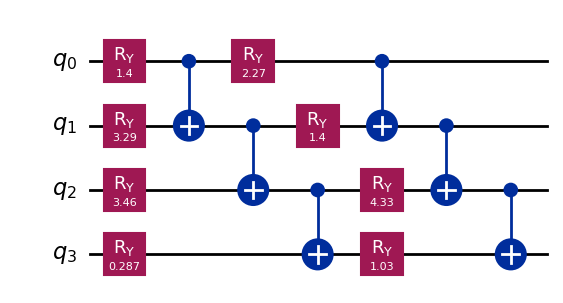

In [4]:
def build_ansatz(num_qubits, depth, params):

    circuit = QuantumCircuit(num_qubits)
    
    # Reshape parameter vector given arguments
    param_matrix = params.reshape((depth, num_qubits))
    
    for layer in range(depth):
        # Ry rotations
        for q in range(num_qubits):
            circuit.ry(param_matrix[layer, q], q)
        
        # Entangling CNOTs between neighbors
        for q in range(num_qubits - 1):
            circuit.cx(q, q + 1)
    
    return circuit


# Example circuit
example_params = np.random.uniform(0, 2*np.pi, NUM_QUBITS * 2)
example_circuit = build_ansatz(NUM_QUBITS, depth=2, params=example_params)
example_circuit.draw("mpl")


## Cost Function

VQE needs a **cost function**: for a given set of parameters $\theta$, we want to compute
the energy

$$
E(\theta) = \bra{\psi(\theta)} H \ket{\psi(\theta)},
$$

where $\ket{\psi(\theta)} = U(\theta) \ket{0 \cdots 0}$ is the state prepared by our ansatz.

In a real experiment, we would estimate $E(\theta)$ by measuring each Pauli string
in the Hamiltonian and averaging over many shots. For now, we keep things simpler and
use the **statevector simulator**:

1. Build the ansatz circuit $U(\theta)$,
2. Use `Statevector` to get the full state $\ket{\psi(\theta)}$,
3. Compute the expectation value with the matrix $H$:

$$
E(\theta) = \psi(\theta)^\dagger \, H \, \psi(\theta).
$$

This gives us a clean, noiseless cost function that we can pass to a classical optimizer.
Later, we will replace this with a **noisy / shot-based** version.


In [5]:
# Choose the ansatz depth
DEPTH = 2

def prepare_state(depth, params):

    params = np.asarray(params, dtype=float)
    
    circuit = build_ansatz(NUM_QUBITS, depth, params)

    state = Statevector.from_instruction(circuit)

    return state

# Cost function: energy expectation value
def energy_expectation(depth, params):

    state = prepare_state(depth, params)

    psi = state.data 
    
    H_psi = H_matrix @ psi
    energy = np.vdot(psi, H_psi)

    return float(np.real(energy))


# Test
theta_test = np.random.uniform(0, 2*np.pi, num_params_for_depth(DEPTH))
E_test = energy_expectation(DEPTH, theta_test)
print("Energy for random parameters:", E_test)


Energy for random parameters: -0.847081300076668


## Noiseless VQE Optimization

With the cost function defined, we can now run VQE in an ideal (noise-free) setting.
The steps are:

1. Initialize the parameter vector $\theta$ randomly,
2. Call a classical optimizer to minimize the energy function,
3. Record the energy at each iteration,
4. Extract the final optimized energy $E_{\text{VQE}}$.

We use the COBYLA optimizer here because it does not require gradients and works well
with small parameter sets. Since we are using the statevector simulator, this run is
fully deterministic and represents the *best possible* performance of our ansatz.


In [6]:
from scipy.optimize import minimize
def run_noiseless_vqe(depth, maxiter=500):
    # Random initial guess
    theta0 = np.random.uniform(0, 2*np.pi, num_params_for_depth(depth))

    energy_history = []

    def cost_fn(theta):
        return energy_expectation(depth, theta)
    
    def callback(theta):    
        E = energy_expectation(depth, theta)
        energy_history.append(E)

    # Run optimization
    optimization_result = minimize(
        cost_fn,
        x0=theta0,
        method="COBYLA",
        callback=callback,
        options={"maxiter": maxiter, "disp": False}
    )

    theta_opt = optimization_result.x
    E_vqe_final = energy_expectation(depth, theta_opt)

    return optimization_result, energy_history, E_vqe_final

## Results: Noiseless VQE vs Exact Ground State

We can now compare the **noiseless VQE result** with the **exact ground-state energy**.

- The exact energy $E_{\text{exact}}$ comes from diagonalizing the full Hamiltonian matrix.
- The VQE energy $E_{\text{VQE}}$ is the minimum value found by COBYLA using our
  depth-2 ansatz.

In an ideal world, if the ansatz could represent the true ground state perfectly and
the optimizer found the global minimum, we would have

$$
E_{\text{VQE}} \approx E_{\text{exact}}.
$$

In practice, for our 4-qubit Heisenberg chain and relatively shallow depth-2 circuit:

- VQE **does lower the energy** significantly compared to random parameters,
- but it **stops well above** the exact ground-state energy.

This tells us that our chosen ansatz is **not expressive enough** to perfectly capture
the true ground state for this model and system size. Later, we will briefly compare
different ansatz depths to see how this affects the final energy.


<<< Noiseless VQE Overview >>>
Number of qubits:           4
Ansatz depth (layers):      2
Exact ground-state energy:  -6.464102
Final VQE energy:           -6.123103
Absolute error:             0.340999
Relative error:             5.28%


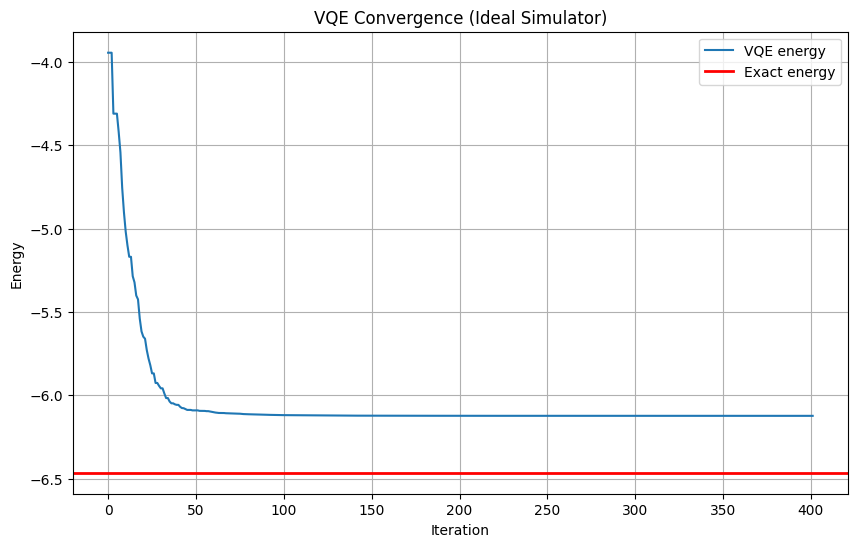

In [7]:
opt_res_ideal, energy_history, E_vqe_final = run_noiseless_vqe(depth=2)

print("<<< Noiseless VQE Overview >>>")
print(f"Number of qubits:           {NUM_QUBITS}")
print(f"Ansatz depth (layers):      {DEPTH}")
print(f"Exact ground-state energy:  {E_exact:.6f}")
print(f"Final VQE energy:           {E_vqe_final:.6f}")

abs_err = abs(E_vqe_final - E_exact)
print(f"Absolute error:             {abs_err:.6f}")

if abs(E_exact) > 1e-8:
    rel_err = abs_err / abs(E_exact)
else:
    rel_err = 0.0  

print(f"Relative error:             {100 * rel_err:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(energy_history, label="VQE energy")
plt.axhline(E_exact, color='r', linewidth=2, label="Exact energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence (Ideal Simulator)")
plt.legend()
plt.grid(True)
plt.show()


## Noisy VQE 

Qiskit provides **fake backends** that mimic real IBM devices. We can:

1. Take a fake backend (with real calibration data),
2. Extract its noise model,
3. Use that noise model in an `AerSimulator`,
4. Run VQE using **shot-based measurements** under this realistic noise.

The rest of the logic is the same: for each Pauli string in $H$, we estimate
its expectation value from bitstring statistics and combine them to get
$$
E(\theta) = \sum_k h_k \langle P_k \rangle.
$$


In [8]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
from qiskit import transpile

# fake backend with realistic noise
fake_backend = FakeVigoV2()

# Build a noise model from the fake backend
noise_model = NoiseModel.from_backend(fake_backend)
coupling_map = fake_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Noisy simulator backend
noisy_backend = AerSimulator(
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates,
)

print("Using fake backend:", fake_backend.configuration().backend_name)
print("Number of physical qubits:", fake_backend.configuration().n_qubits)
print("Basis gates:", basis_gates)


Using fake backend: fake_vigo
Number of physical qubits: 5
Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']


### Estimating a single Pauli string expectation value

To compute the energy, we need expectation values of each Pauli string in the
Hamiltonian. In this cell we:

- convert raw measurement counts into an expectation value $\langle P \rangle$
- build a measurement circuit for a given Pauli string
- apply the correct basis-change gates (for $X$ or $Y$)
- run the circuit on the noisy backend and estimate $\langle P \rangle$ from bitstring (measurement output) statistics


In [9]:
from qiskit import ClassicalRegister

# Hyperparameter (adjustable if desired)
SHOTS = 2000

# We calculate the expectation value of a Pauli string from the count of 
# bitstrings (measurement output)
def pauli_expectation_from_counts(pauli_string, counts):

    total_shots = sum(counts.values())
    if total_shots == 0:
        return 0.0
    
    # So we can adjust number of qubits if desired
    num_qubits = len(pauli_string)
    exp_val = 0.0

    for bitstring, cnt in counts.items():

        value = 1
        # I no influence on eigenvalue
        for q, p in enumerate(pauli_string):
            if p == "I":
                continue

            bit = bitstring[num_qubits - 1 - q]

            z_eigen = 1 if bit == "0" else -1

            value *= z_eigen

        exp_val += (value * cnt)

    return (exp_val / total_shots)

# Uses ansatz circuit and runs on noisy backend. 
# Then estimates expectation value of a Pauli string.
def noisy_expectation_for_pauli(pauli_string, depth, params):

    num_qubits = len(pauli_string)
    
    # ansatz circuit
    qc = build_ansatz(num_qubits, depth, params)

    # needed for measurement
    reg = ClassicalRegister(num_qubits)
    qc.add_register(reg)

    # Basis changes so we can measure in correct basis (Z: ket {0, 1})
    # X: apply H, Y: apply adjoint phase gate + H
    for q, p in enumerate(pauli_string):
        if p == "X":
            qc.h(q)
        elif p == "Y":
            qc.sdg(q)
            qc.h(q)
        

    qc.measure(range(num_qubits), range(num_qubits))

    # Transpile "makes usable circuit"
    transpiled_qc = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=0,
    )

    # Run on noisy backend
    job = noisy_backend.run(transpiled_qc, shots=SHOTS)
    result = job.result()
    counts = result.get_counts()

    return pauli_expectation_from_counts(pauli_string, counts)


### Noisy energy cost function

Using the single-Pauli estimator from above, we now construct the full noisy
energy function

$$
E(\theta) = \sum_k h_k \langle P_k \rangle.
$$

For each term $h_k P_k$ in the Heisenberg Hamiltonian, we:

- estimate $\langle P_k \rangle$ using the noisy backend
- multiply by its coefficient $h_k$
- sum everything to obtain the total energy for the current parameters $\theta$

This gives us a noisy version of the same cost function we used in the ideal case.


In [10]:
# Computes sum of all weighted Pauli Strings in the Hamiltonian
def energy_expectation_noisy(depth, params):

    params = np.asarray(params, dtype=float)

    pauli_labels = H.paulis.to_labels()
    coeffs = np.asarray(H.coeffs, dtype=complex)

    energy = 0.0
    for p_str, w in zip(pauli_labels, coeffs):
        exp_p = noisy_expectation_for_pauli(p_str, depth, params)
        energy += float(np.real(w)) * exp_p

    return float(energy)


# Test
theta_test = np.random.uniform(0, 2*np.pi, num_params_for_depth(DEPTH))
E_test_noisy = energy_expectation_noisy(DEPTH, theta_test)
print("Noisy energy estimate for random parameters:", E_test_noisy)


Noisy energy estimate for random parameters: 0.06200000000000003


### Running noisy VQE

VQE using the **noisy** energy function.

- We start from random parameters $\theta$
- use COBYLA to minimize the noisy energy
- record the energy at each iteration
- and compare the final noisy VQE energy with the ideal VQE result and the exact energy

Because of noise and finite shots, the optimization should be less smooth and 
converge to a higher energy than in the ideal case.


In [11]:
from scipy.optimize import minimize

def run_vqe_noisy(depth, maxiter=60):
    energy_history_noisy = []


    def cost_fn(theta):
        return energy_expectation_noisy(depth, theta)
    # computes energy estimate and appends to history
    def callback_noisy(theta):
        E = energy_expectation_noisy(depth, theta)
        energy_history_noisy.append(E)

    # Random initial parameters
    theta0_noisy = np.random.uniform(0, 2*np.pi, num_params_for_depth(depth))

    # Run optimization
    result_noisy = minimize(
        cost_fn,
        x0=theta0_noisy,
        method="COBYLA",
        callback=callback_noisy,
        options={"maxiter": maxiter, "disp": False}
    )

    # extract optimization results
    theta_opt_noisy = result_noisy.x
    E_vqe_noisy_final = energy_expectation_noisy(depth, theta_opt_noisy)
    return result_noisy, energy_history_noisy, E_vqe_noisy_final

## Comparing Ideal and Noisy VQE

Compare three energies:

- the **exact** ground-state energy
- the **ideal VQE** energy from the statevector simulator,
- the **noisy VQE** energy from the fake backend noise model.

In the ideal case, the cost function is evaluated exactly and cheaply, so we allowed
more optimizer steps. In the noisy case, each evaluation requires many circuit
executions and thousands of shots, so we limited the optimizer to fewer iterations
to reflect realistic hardware constraints.

We expect to see that the noisy VQE outputs a worse approximation of the 
ground-state energy due to the simulation noise and the complexity created by 
requiring multiple circuit executions (shots) per evaluation.

Number of ideal iterations: 402
Number of noisy iterations: 33


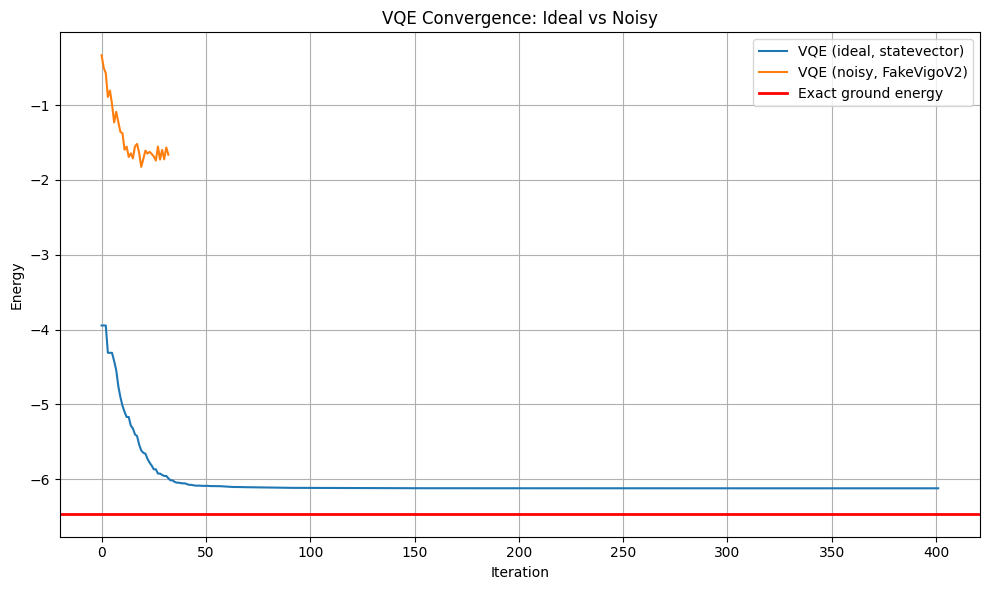

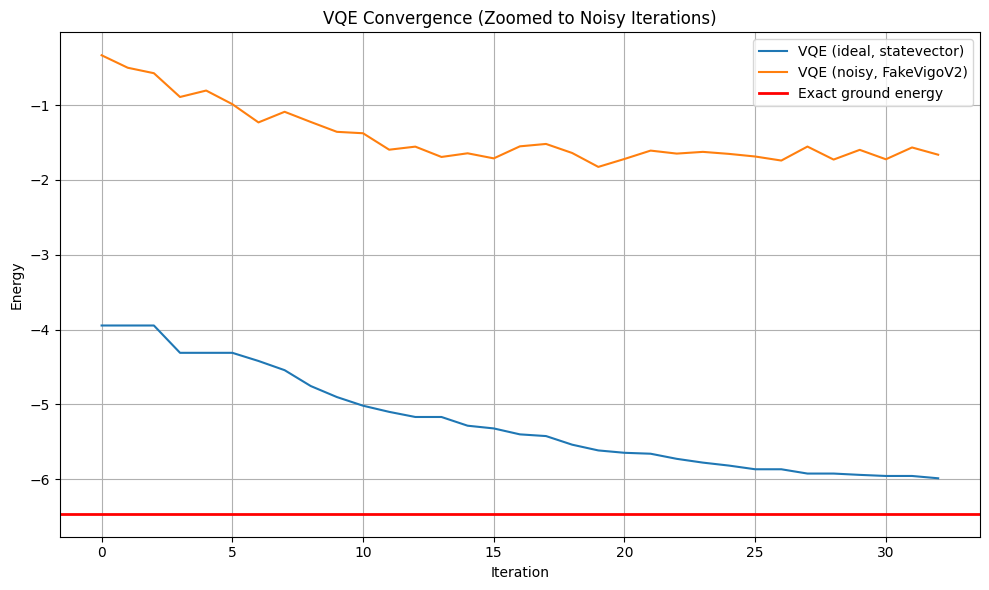


<<< Energy Comparison >>>
Exact ground energy:        -6.464102
Ideal VQE energy (depth 2): -6.123103
Noisy VQE energy:           -1.652000

Absolute error (ideal):     0.340999
Absolute error (noisy):     4.812102
Relative error (ideal):     5.28%
Relative error (noisy):     74.44%


In [12]:
result_noisy, energy_history_noisy, E_vqe_noisy_final = run_vqe_noisy(depth=2, maxiter=60)

print(f"Number of ideal iterations: {len(energy_history)}")
print(f"Number of noisy iterations: {len(energy_history_noisy)}")

plt.figure(figsize=(10, 6))

# Plot ideal VQE curve
plt.plot(energy_history, label="VQE (ideal, statevector)")

# Plot noisy VQE curve
plt.plot(energy_history_noisy, label="VQE (noisy, FakeVigoV2)")

# Exact energy as a horizontal line
plt.axhline(E_exact, color="red", linewidth=2, label="Exact ground energy")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence: Ideal vs Noisy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


iters_ideal = np.arange(len(energy_history))
iters_noisy = np.arange(len(energy_history_noisy))

plt.figure(figsize=(10, 6))

# Only plot ideal for the same number of iterations as noisy
cut = len(energy_history_noisy)
plt.plot(iters_ideal[:cut], energy_history[:cut],
         label="VQE (ideal, statevector)")

plt.plot(iters_noisy, energy_history_noisy,
         label="VQE (noisy, FakeVigoV2)")

plt.axhline(E_exact, color="red", linewidth=2, label="Exact ground energy")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence (Zoomed to Noisy Iterations)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print("\n<<< Energy Comparison >>>")
print(f"Exact ground energy:        {E_exact:.6f}")
print(f"Ideal VQE energy (depth 2): {E_vqe_final:.6f}")
print(f"Noisy VQE energy:           {E_vqe_noisy_final:.6f}")

err_ideal = abs(E_vqe_final - E_exact)
err_noisy = abs(E_vqe_noisy_final - E_exact)

print(f"\nAbsolute error (ideal):     {err_ideal:.6f}")
print(f"Absolute error (noisy):     {err_noisy:.6f}")

if abs(E_exact) > 1e-8:
    print(f"Relative error (ideal):     {100 * err_ideal / abs(E_exact):.2f}%")
    print(f"Relative error (noisy):     {100 * err_noisy / abs(E_exact):.2f}%")


## Comparing Ansatz Depths

To understand how ansatz expressiveness and noise interact, we compare
ansatz depths and measure the final VQE energy for depths of $1$, $2$, and $3$.

We will run this comparison for both the ideal and noisy VQE implementations.


<<< Noiseless VQE Overview (depth = 1) >>>
Number of qubits:           4
Ansatz depth (layers):      1
Exact ground-state energy:  -6.464102
Final VQE energy:           -3.500001
Absolute error:             2.964100
Relative error:             45.85%

<<< Noiseless VQE Overview (depth = 2) >>>
Number of qubits:           4
Ansatz depth (layers):      2
Exact ground-state energy:  -6.464102
Final VQE energy:           -6.123073
Absolute error:             0.341028
Relative error:             5.28%

<<< Noiseless VQE Overview (depth = 3) >>>
Number of qubits:           4
Ansatz depth (layers):      3
Exact ground-state energy:  -6.464102
Final VQE energy:           -6.462628
Absolute error:             0.001473
Relative error:             0.02%


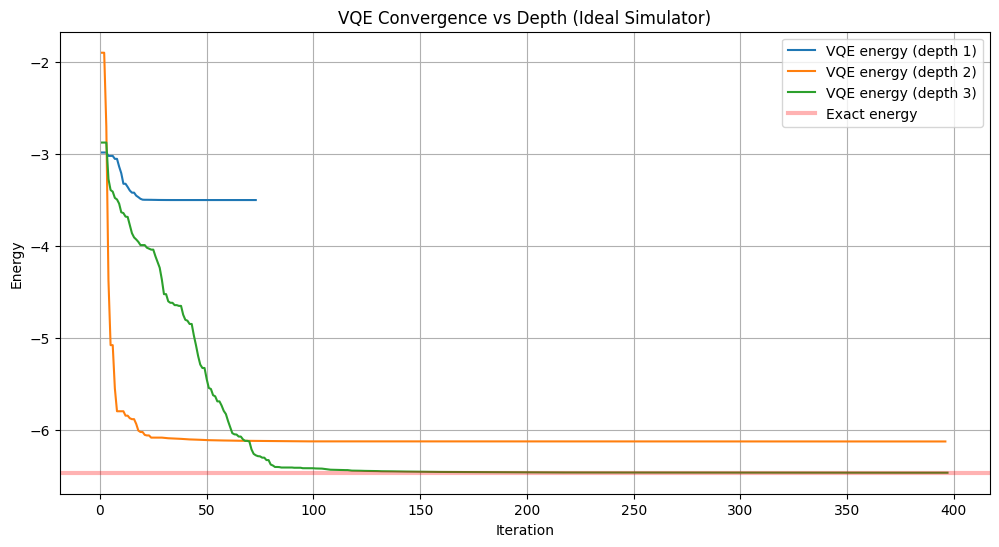

In [ ]:
depths = [1, 2, 3]

energy_histories = {}
final_energies = {}

for d in depths:
    opt_res_ideal, energy_history, E_vqe_final = run_noiseless_vqe(depth=d)
    energy_histories[d] = energy_history
    final_energies[d] = E_vqe_final

    print(f"\n<<< Noiseless VQE Overview (depth = {d}) >>>")
    print(f"Number of qubits:           {NUM_QUBITS}")
    print(f"Ansatz depth (layers):      {d}")
    print(f"Exact ground-state energy:  {E_exact:.6f}")
    print(f"Final VQE energy:           {E_vqe_final:.6f}")

    abs_err = abs(E_vqe_final - E_exact)
    print(f"Absolute error:             {abs_err:.6f}")

    if abs(E_exact) > 1e-8:
        rel_err = abs_err / abs(E_exact)
    else:
        rel_err = 0.0  

    print(f"Relative error:             {100 * rel_err:.2f}%")




plt.figure(figsize=(12, 6))

for d in depths:
    hist = energy_histories[d]
    iters = range(1, len(hist) + 1)
    plt.plot(iters, hist, label=f"VQE energy (depth {d})")

plt.axhline(E_exact, color="red", alpha=0.3, linewidth=3, label="Exact energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence vs Depth (Ideal Simulator)")
plt.legend()
plt.grid(True)
plt.show()



<<< Noisy VQE Overview (depth = 1) >>>
Number of qubits:           4
Ansatz depth (layers):      1
Exact ground-state energy:  -6.464102
Final noisy VQE energy:     -4.419000
Absolute error:             2.045102
Relative error:             31.64%

<<< Noisy VQE Overview (depth = 2) >>>
Number of qubits:           4
Ansatz depth (layers):      2
Exact ground-state energy:  -6.464102
Final noisy VQE energy:     -4.132000
Absolute error:             2.332102
Relative error:             36.08%

<<< Noisy VQE Overview (depth = 3) >>>
Number of qubits:           4
Ansatz depth (layers):      3
Exact ground-state energy:  -6.464102
Final noisy VQE energy:     -4.540000
Absolute error:             1.924102
Relative error:             29.77%


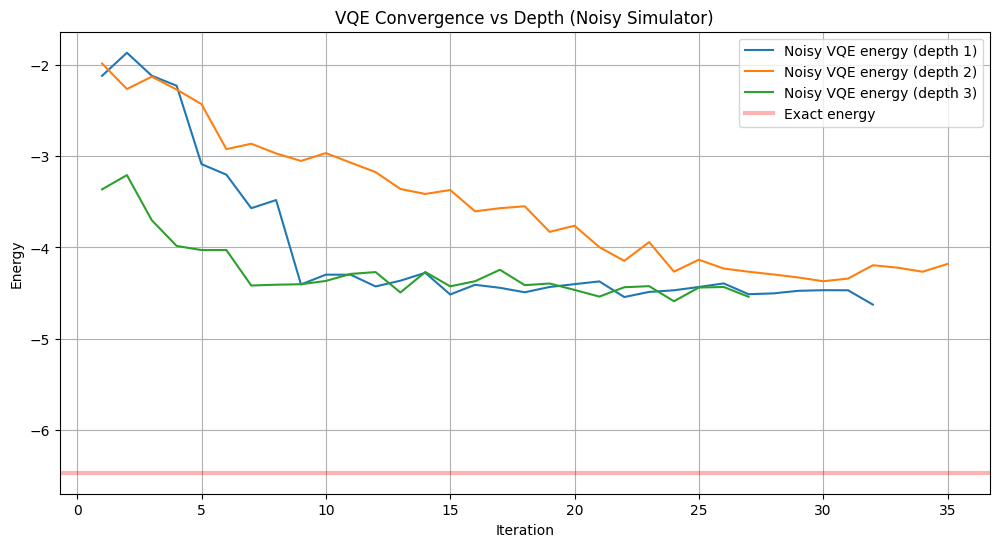

In [22]:
depths = [1, 2, 3]

energy_histories_noisy = {}
final_energies_noisy = {}

for d in depths:
    opt_res_noisy, energy_history_noisy, E_vqe_noisy_final = run_vqe_noisy(depth=d)
    energy_histories_noisy[d] = energy_history_noisy
    final_energies_noisy[d] = E_vqe_noisy_final

    print(f"\n<<< Noisy VQE Overview (depth = {d}) >>>")
    print(f"Number of qubits:           {NUM_QUBITS}")
    print(f"Ansatz depth (layers):      {d}")
    print(f"Exact ground-state energy:  {E_exact:.6f}")
    print(f"Final noisy VQE energy:     {E_vqe_noisy_final:.6f}")

    abs_err = abs(E_vqe_noisy_final - E_exact)
    print(f"Absolute error:             {abs_err:.6f}")

    if abs(E_exact) > 1e-8:
        rel_err = abs_err / abs(E_exact)
    else:
        rel_err = 0.0  

    print(f"Relative error:             {100 * rel_err:.2f}%")


plt.figure(figsize=(12, 6))

for d in depths:
    hist = energy_histories_noisy[d]
    iters = range(1, len(hist) + 1)
    plt.plot(iters, hist, label=f"Noisy VQE energy (depth {d})")

plt.axhline(E_exact, color="red", alpha=0.3, linewidth=3, label="Exact energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence vs Depth (Noisy Simulator)")
plt.legend()
plt.grid(True)
plt.show()
